In [1]:
from City import *
from Mass import *
import mplleaflet
import matplotlib.pyplot as plt 

In [2]:
Hamburg = City(53.5488, 9.9872, 0.3, 0.5)

In [3]:
mass = Mass()
mass.load_json_file('cm_logs/20220624_214724.txt')
plt.plot(mass.get_long(),mass.get_lat(),'b.')
mplleaflet.display()

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [4]:
mass.remove_points_outside_window(Hamburg.get_window())
mass.remove_points_outside_circle(Hamburg.get_center(),20)
plt.plot(mass.get_long(),mass.get_lat(),'b.')
mplleaflet.display()

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [5]:
from scipy.spatial import distance

In [29]:
test = np.ones(len(mass.positions))
test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [44]:
def filter_train(mass,subset=':',debug=0,n_next=5,crit_thr=6):
    if subset==':':
        subset = np.full(len(mass.positions),True)
    positions = mass.positions[subset]
    # Calculate distance maps, using geopy gedoesic as custom distance function
    # see https://stackoverflow.com/questions/31632190/measuring-geographic-distance-with-scipy
    # VERY costly function because geopy_distance.geodesic is slow
    D = distance.squareform(distance.pdist(positions, lambda u, v: geopy_distance.great_circle(u,v).m))
    closest = np.argsort(D, axis=1) #each line represents closest point indices
    crit = np.mean(np.sort(D,axis=1)[:,1:n_next+1],axis=1)
    if debug:
        counts,edges = np.histogram(crit,bins=101)
        plt.stairs(counts,edges,fill=True)
        plt.show()
        plt.figure(figsize=(6,6))
        print('Median:',np.median(crit))
    selec = crit<crit_thr*np.median(crit)
    # Return point list and distance matrix because it is computationally expensive to calculate
    #D[np.ix_(selec,selec)
    subset_train = np.full(len(mass.positions),False);
    for ii,s in enumerate(subset):
        if s:
            subset_train[ii] = selec[sum(subset[0:ii])]
    return subset_train,positions[selec],D[np.ix_(selec,selec)]

idx_train,positions_train,D_train=filter_train(mass,n_next=5,crit_thr=4,debug=0)
plt.plot(mass.get_long(),mass.get_lat(),'xr')
plt.plot(mass.get_long()[idx_train],mass.get_lat()[idx_train], 'ob', ms=3, mew=2);
mplleaflet.display()

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [7]:
def find_starting_point_idx(positions):
    # Find outermost point with the largest distance to the mean of all points
    mean = np.median(positions,axis=0)
    #print(mean)
    dist_to_mean = [geopy_distance.great_circle(p,mean).m for p in positions]
    return np.argmax(dist_to_mean)
    
def sort_points(mass,subset=':',D): 
    TODO continue here
    if subset==':':
        subset = np.full(len(mass.positions),True)
    positions = mass.positions[subset]
    closest1_avg = np.argsort(D, axis=1) #each line represents closest point indices
    # Reorder points according to closest points (second column in closest1_avg, first column points to point itself)
    sorted_points_idx = []
    next_point = find_starting_point_idx(positions) # can fail
    # Greedy algorithm first round
    for ii in range(0,len(positions)):
        sorted_points_idx.append(next_point)
        ii_neighbor = 0
        while len(sorted_points_idx) < len(positions) and next_point in sorted_points_idx:
            next_point = closest1_avg[sorted_points_idx[-1],ii_neighbor] # Check neighbors of last point
            ii_neighbor = ii_neighbor + 1
    sorted_points = positions[sorted_points_idx]
    # Find largest distance in train + distance between supposed starting point and final point
    distances = [geopy_distance.great_circle(sorted_points[0],sorted_points[-1]).m]
    distances.extend([geopy_distance.great_circle(u,v).m for u,v in zip(sorted_points[:-1],sorted_points[1:])])
    idx_maximum_distance = np.argmax(distances) #is 0 if largest distance between current start and end point
    if idx_maximum_distance!=0:
        sorted_points_idx = np.concatenate((np.flip(sorted_points_idx[idx_maximum_distance:]),sorted_points_idx[0:idx_maximum_distance]))
    # Greedy algorithm second round backwards
    next_point = sorted_points_idx[-1]
    sorted_points_idx_new = []
    # Greedy algorithm second round -> removes any remaining turn in loop
    for ii in range(0,len(sorted_points_idx)):
        sorted_points_idx_new.append(next_point)
        ii_neighbor = 0
        while len(sorted_points_idx_new) < len(positions) and next_point in sorted_points_idx_new:
            next_point = closest1_avg[sorted_points_idx_new[-1],ii_neighbor] # Check neighbors of last point
            ii_neighbor = ii_neighbor + 1
    sorted_points_idx = sorted_points_idx_new;    
    sorted_points = positions[sorted_points_idx]
    # Resort also distance array
    sorted_D = np.empty_like(D)
    for ii,x in enumerate(D):
        for jj,y in enumerate(x):
            sorted_D[ii,jj] = D[sorted_points_idx[ii],sorted_points_idx[jj]]
    return sorted_points_idx,sorted_points,sorted_D

idx_sorted,positions_sorted,D_sorted = sort_points(mass,subset=idx_train,D_train)

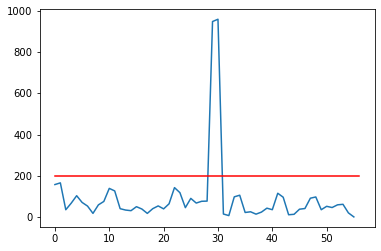

In [19]:
neighbor_dist = np.zeros(len(positions_sorted))
n=3;
for ii in range(len(positions_sorted)):
    neighbor_dist[ii] = np.median(D_sorted[ii,min(len(positions_sorted)-1,ii+1):min(len(positions_sorted),ii+n+1)])
outlier_threshold = 200;
plt.plot(neighbor_dist)
plt.plot([0,len(neighbor_dist)],[outlier_threshold,outlier_threshold],'r-')
idx_main_train = neighbor_dist<outlier_threshold;
positions_main_train = positions_sorted[idx_main_train]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 99 but corresponding boolean dimension is 56

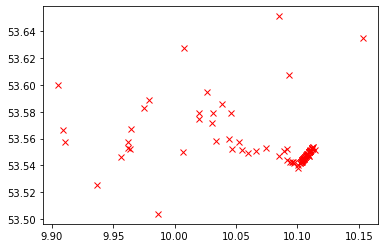

In [20]:
plt.plot(mass.get_long(),mass.get_lat(),'xr')
plt.plot(mass.get_long()[idx_main_train],mass.get_lat()[idx_main_train], 'ob', ms=3, mew=2);
mplleaflet.display()